<a href="https://colab.research.google.com/github/Vats2025/Industrial-Gas-Leak-Detection-System/blob/main/GAS__DETECTION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import os

print(" Upload your 'gas_leak_detection_dataset.csv' file...")
uploaded = files.upload()

print("\n Files uploaded:")
for filename in uploaded.keys():
    print(f"  • {filename}")


 Upload your 'gas_leak_detection_dataset.csv' file...


Saving gas_leak_detection_dataset.csv to gas_leak_detection_dataset (1).csv

 Files uploaded:
  • gas_leak_detection_dataset (1).csv


In [10]:
print(" GAS LEAK DETECTION SYSTEM - USING CSV DATA")
print("Shows ALL 5 severity levels with probabilities")

 GAS LEAK DETECTION SYSTEM - USING CSV DATA
Shows ALL 5 severity levels with probabilities


# INSTALL & IMPORT

In [4]:
print("\n Loading required libraries...")

import subprocess
import sys
import os

def install_if_missing(package):
    try:
        __import__(package)
        return True
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return False

packages = ['scikit-learn', 'pandas', 'numpy', 'joblib', 'matplotlib']
for pkg in ['sklearn', 'pandas', 'numpy', 'joblib', 'matplotlib']:
    install_if_missing(pkg)

import numpy as np
import pandas as pd
import joblib
import warnings
warnings.filterwarnings('ignore')

print(" Libraries loaded!")


 Loading required libraries...
 Libraries loaded!


# LOAD CSV DATA

In [5]:
def load_csv_data():
    """Load the CSV file with proper error handling"""
    print("\n" + "="*60)
    print(" LOADING GAS LEAK DATASET")
    print("="*60)

    csv_files = [f for f in os.listdir('.') if f.endswith('.csv') and 'gas_leak' in f.lower()]

    if not csv_files:
        print("\n No gas leak CSV file found!")
        print("\nPlease make sure you have 'gas_leak_detection_dataset.csv' in the current directory.")
        print("\nThe CSV should have these columns:")
        print("  • gas_concentration_ppm")
        print("  • temperature_c")
        print("  • pressure_psi")
        print("  • proximity_cm")
        print("  • humidity_percent")
        print("  • acoustic_db")
        print("  • leak_severity (0-4)")
        return None

    csv_file = csv_files[0]
    print(f"\n Found CSV file: {csv_file}")

    try:
        df = pd.read_csv(csv_file)

        print(f" Data loaded successfully!")
        print(f" Dataset shape: {df.shape}")
        print(f" Columns: {list(df.columns)}")

        print("\n DATASET INFORMATION:")
        print("-" * 40)
        print(df.describe())

        print("\n TARGET DISTRIBUTION:")
        severity_names = ['Normal', 'Minor', 'Moderate', 'Significant', 'Severe']
        severity_counts = df['leak_severity'].value_counts().sort_index()
        for severity, count in severity_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  • Severity {severity} ({severity_names[severity]}): {count} samples ({percentage:.1f}%)")

        return df

    except Exception as e:
        print(f" Error loading CSV: {str(e)}")
        return None

# TRAIN MODEL

In [6]:
def train_model(df):
    """Train model using the CSV data"""
    print("\n" + "="*60)
    print(" TRAINING MODEL")
    print("="*60)

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    X = df.drop('leak_severity', axis=1)
    y = df['leak_severity']

    print(f"\n Features: {list(X.columns)}")
    print(f" Target: leak_severity (0-4)")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\n Data split:")
    print(f"  • Training samples: {len(X_train)}")
    print(f"  • Testing samples: {len(X_test)}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\n Training Random Forest model...")
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    )
    model.fit(X_train_scaled, y_train)

    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)

    print(f"\n Model trained successfully!")
    print(f" Training Accuracy: {train_acc:.2%}")
    print(f" Testing Accuracy: {test_acc:.2%}")

    joblib.dump(model, 'gas_leak_model_real.pkl')
    joblib.dump(scaler, 'gas_leak_scaler_real.pkl')
    joblib.dump(list(X.columns), 'gas_leak_features_real.pkl')

    print("\n Model saved to:")
    print("  • gas_leak_model_real.pkl")
    print("  • gas_leak_scaler_real.pkl")
    print("  • gas_leak_features_real.pkl")

    return model, scaler, X.columns, X_test_scaled, y_test

# INTERACTIVE PREDICTION

In [7]:
 def get_user_input_real(feature_names):
    """Get sensor values from user using CSV column names"""
    print("\n" + "="*60)
    print(" ENTER SENSOR VALUES (from CSV)")
    print("="*60)

    print("\n TYPICAL RANGES from your CSV:")
    print("  • gas_concentration_ppm: 0-911 ppm (Normal: 0-50 ppm)")
    print("  • temperature_c: 1416-1577°C (Normal: 1525-1530°C)")
    print("  • pressure_psi: 11-104 psi (Normal: 75-85 psi)")
    print("  • proximity_cm: 9.5-16.9 cm (Normal: 10-11 cm)")
    print("  • humidity_percent: 23-79% (Normal: 40-45%)")
    print("  • acoustic_db: 58-150 dB (Normal: 70-90 dB)")
    print()

    values = {}
    for feature in feature_names:
        prompt = f"Enter {feature}: "

        if 'gas_concentration' in feature:
            default = "20"
        elif 'temperature' in feature:
            default = "1526"
        elif 'pressure' in feature:
            default = "76"
        elif 'proximity' in feature:
            default = "10.9"
        elif 'humidity' in feature:
            default = "43"
        elif 'acoustic' in feature:
            default = "84"
        else:
            default = "0"

        user_input = input(prompt)
        values[feature] = float(user_input) if user_input else float(default)

    return values

def make_prediction_real(values, model, scaler):
    """Make prediction using the real model"""

    df_input = pd.DataFrame([values])

    df_input = df_input[list(values.keys())]

    scaled = scaler.transform(df_input)

    predicted_class = model.predict(scaled)[0]
    probabilities = model.predict_proba(scaled)[0]

    return predicted_class, probabilities

def display_all_results_real(predicted_class, probabilities, values):
    """Display ALL 5 results with details"""
    print("\n" + "="*60)
    print(" COMPLETE PREDICTION RESULTS")
    print("="*60)

    severity_levels = [
        {
            'name': 'LEVEL 0: NORMAL',
            'description': 'No gas leak detected',
            'color': '🟢',
            'action': 'Continue normal operations',
            'threshold': 'All parameters within normal range'
        },
        {
            'name': 'LEVEL 1: MINOR',
            'description': 'Very slight gas presence',
            'color': '🟡',
            'action': 'Increase monitoring frequency',
            'threshold': 'Gas < 50 ppm, Minor anomalies'
        },
        {
            'name': 'LEVEL 2: MODERATE',
            'description': 'Minor leak requiring attention',
            'color': '🟠',
            'action': 'Schedule inspection within 12 hours',
            'threshold': 'Gas 50-200 ppm, Multiple anomalies'
        },
        {
            'name': 'LEVEL 3: SIGNIFICANT',
            'description': 'Significant leak - Safety concern',
            'color': '🔴',
            'action': 'Immediate inspection & area isolation',
            'threshold': 'Gas 200-400 ppm, Critical parameters high'
        },
        {
            'name': 'LEVEL 4: SEVERE',
            'description': 'Emergency - Major leak detected',
            'color': '⚫',
            'action': 'FULL EMERGENCY SHUTDOWN - Evacuate immediately',
            'threshold': 'Gas > 400 ppm, Multiple critical failures'
        }
    ]

    print("\n INPUT SENSOR VALUES:")
    for key, value in values.items():
        print(f"   • {key:25}: {value:10.2f}")

    print("\n" + "="*60)

    print(f"\n FINAL PREDICTION: {severity_levels[predicted_class]['color']}")
    print(f"   {severity_levels[predicted_class]['name']}")
    print(f"   {severity_levels[predicted_class]['description']}")
    print(f"    ACTION: {severity_levels[predicted_class]['action']}")

    print("\n" + "="*60)

    print("\n DETAILED PROBABILITIES FOR ALL 5 LEVELS:")
    print("-" * 60)

    for i in range(5):
        prob = probabilities[i] * 100
        level = severity_levels[i]

        bar_length = int(prob / 5)  # Scale to 20 characters max
        bar = "█" * bar_length + "░" * (20 - bar_length)

        if i == predicted_class:
            indicator = "🎯"
        elif prob > 30:
            indicator = "⚠️ "
        else:
            indicator = "   "

        print(f"{indicator} {level['color']} {level['name'][:20]:20} [{bar}] {prob:6.2f}%")

    print("-" * 60)
    print(f"   🎯 = Predicted level | ⚠️  = High probability")

    print("\n" + "="*60)

    print("\n CONFIDENCE ANALYSIS:")
    max_prob = np.max(probabilities) * 100
    second_max = np.sort(probabilities)[-2] * 100

    if max_prob > 80:
        print(f"   High confidence: {max_prob:.1f}% certainty")
    elif max_prob > 60:
        print(f"   Moderate confidence: {max_prob:.1f}% certainty")
    else:
        print(f"   Low confidence: Only {max_prob:.1f}% certainty")
        print(f"   Alternative: Level {np.argsort(probabilities)[-2]} ({second_max:.1f}%)")

    gas_level = values.get('gas_concentration_ppm', 0)
    print("\n SAFETY PROTOCOL BASED ON GAS LEVELS:")
    print(f"   Current Gas Concentration: {gas_level:.1f} ppm")

    if predicted_class == 0:
        print("   • Normal operations")
        print("   • Standard monitoring (hourly checks)")
        print("   • Ventilation: Normal operation")
    elif predicted_class == 1:
        print("   • INCREASED MONITORING (every 15 minutes)")
        print("   • Visual inspection of suspected areas")
        print("   • Check all seals and connections")
        print("   • Ventilation: Increase by 20%")
    elif predicted_class == 2:
        print("   • ALERT MAINTENANCE TEAM IMMEDIATELY")
        print("   • Isolate affected area")
        print("   • Prepare shutdown procedures")
        print("   • Ventilation: Maximum safe setting")
        print("   • PPE Required: Gas masks")
    elif predicted_class == 3:
        print("   • 🚨 PARTIAL EVACUATION (non-essential personnel)")
        print("   • Activate emergency ventilation")
        print("   • Shut down non-critical equipment")
        print("   • Call emergency response team")
        print("   • PPE Required: Full SCBA gear")
    else:  # Level 4
        print("   •  EMERGENCY ALARM - Sound all alarms")
        print("   •  FULL EVACUATION - Clear entire facility")
        print("   •  EMERGENCY SERVICES - Call 911")
        print("   •  TOTAL SHUTDOWN - Cut all power/gas")
        print("   •  DO NOT use phones/electrical devices")
        print("   •  Establish 500m exclusion zone")

    print("\n" + "="*60)

    try:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 6))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        colors = ['green', 'yellow', 'orange', 'red', 'black']
        levels = ['Level 0\nNormal', 'Level 1\nMinor', 'Level 2\nModerate',
                 'Level 3\nSignificant', 'Level 4\nSevere']

        bars = ax1.bar(levels, probabilities * 100, color=colors, edgecolor='black')

        bars[predicted_class].set_edgecolor('blue')
        bars[predicted_class].set_linewidth(3)

        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{prob*100:.1f}%', ha='center', va='bottom', fontweight='bold')

        ax1.set_title('GAS LEAK SEVERITY PROBABILITIES', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Severity Level', fontsize=12)
        ax1.set_ylabel('Probability (%)', fontsize=12)
        ax1.set_ylim(0, 105)
        ax1.grid(axis='y', alpha=0.3)

        sensor_names = list(values.keys())
        sensor_values = list(values.values())

        normalized_values = [(v - min(sensor_values)) / (max(sensor_values) - min(sensor_values)) * 100
                           if max(sensor_values) > min(sensor_values) else 50
                           for v in sensor_values]

        colors2 = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
        bars2 = ax2.bar(sensor_names, normalized_values, color=colors2[:len(sensor_names)])

        ax2.set_title('SENSOR VALUES (Normalized)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Sensor Type', fontsize=12)
        ax2.set_ylabel('Normalized Value (%)', fontsize=12)
        ax2.set_ylim(0, 110)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()

        plt.savefig('gas_leak_prediction_results.png', dpi=100, bbox_inches='tight')
        print(f"\n Visualization saved as 'gas_leak_prediction_results.png'")

        try:
            plt.show()
        except:
            print("   (Open 'gas_leak_prediction_results.png' to view the chart)")

        plt.close()

    except Exception as e:
        print(f"\n (Chart skipped: {str(e)})")

def run_test_scenarios_real(feature_names):
    """Run through test scenarios using CSV data ranges"""
    print("\n" + "="*60)
    print(" TEST SCENARIOS (based on CSV data)")
    print("="*60)

    scenarios = [
        {
            'name': 'NORMAL OPERATION',
            'values': {
                'gas_concentration_ppm': 20,
                'temperature_c': 1526,
                'pressure_psi': 76,
                'proximity_cm': 10.9,
                'humidity_percent': 43,
                'acoustic_db': 84
            }
        },
        {
            'name': 'MINOR LEAK',
            'values': {
                'gas_concentration_ppm': 60,
                'temperature_c': 1518,
                'pressure_psi': 72,
                'proximity_cm': 10.3,
                'humidity_percent': 48,
                'acoustic_db': 92
            }
        },
        {
            'name': 'MODERATE LEAK',
            'values': {
                'gas_concentration_ppm': 150,
                'temperature_c': 1535,
                'pressure_psi': 68,
                'proximity_cm': 10.8,
                'humidity_percent': 52,
                'acoustic_db': 105
            }
        },
        {
            'name': 'SIGNIFICANT LEAK',
            'values': {
                'gas_concentration_ppm': 350,
                'temperature_c': 1548,
                'pressure_psi': 62,
                'proximity_cm': 11.5,
                'humidity_percent': 65,
                'acoustic_db': 120
            }
        },
        {
            'name': 'SEVERE EMERGENCY',
            'values': {
                'gas_concentration_ppm': 600,
                'temperature_c': 1560,
                'pressure_psi': 55,
                'proximity_cm': 12.8,
                'humidity_percent': 75,
                'acoustic_db': 140
            }
        }
    ]

    print("\nSelect test scenario:")
    for i, scenario in enumerate(scenarios, 1):
        print(f"  {i}. {scenario['name']}")
    print("  6. CUSTOM INPUT")

    choice = input("\nYour choice (1-6): ").strip()

    if choice == '6':
        return None
    try:
        idx = int(choice) - 1
        if 0 <= idx < 5:
            print(f"\n Testing: {scenarios[idx]['name']}")
            return scenarios[idx]['values']
    except:
        pass

    return None

# MAIN PROGRAM

In [8]:
def main():
    """Main program loop"""

    print("\n" + "="*60)
    print(" GAS LEAK DETECTION SYSTEM")
    print("="*60)
    print(" Uses your gas_leak_detection_dataset.csv")
    print(" Shows ALL 5 severity levels with probabilities")
    print(" Real-time prediction system")
    print(" Industrial safety application")
    print("="*60)

    df = load_csv_data()
    if df is None:
        print("\n Cannot continue without CSV data.")
        print("Please add your 'gas_leak_detection_dataset.csv' file and restart.")
        return

    print("\n" + "="*60)
    print(" SETUP OPTIONS")
    print("="*60)
    print("1. Train new model (recommended for first time)")
    print("2. Load existing model (if already trained)")

    setup_choice = input("\nSelect option (1-2): ").strip()

    model = None
    scaler = None
    feature_names = None

    if setup_choice == '1':
        model, scaler, feature_names, X_test, y_test = train_model(df)
    else:
        try:
            model = joblib.load('gas_leak_model_real.pkl')
            scaler = joblib.load('gas_leak_scaler_real.pkl')
            feature_names = joblib.load('gas_leak_features_real.pkl')
            print("\n Existing model loaded successfully!")
        except:
            print("\n Could not load existing model. Training new one...")
            model, scaler, feature_names, X_test, y_test = train_model(df)

    while True:
        print("\n" + "="*60)
        print(" MAIN MENU")
        print("="*60)
        print("1.  Enter sensor values (Custom)")
        print("2.  Run test scenarios")
        print("3.  Show model information")
        print("4.  Retrain model with current data")
        print("5.  Exit")

        choice = input("\nSelect option (1-5): ").strip()

        if choice == '1':
            values = get_user_input_real(feature_names)
            predicted_class, probabilities = make_prediction_real(values, model, scaler)
            display_all_results_real(predicted_class, probabilities, values)

        elif choice == '2':
            values = run_test_scenarios_real(feature_names)
            if values is not None:
                predicted_class, probabilities = make_prediction_real(values, model, scaler)
                display_all_results_real(predicted_class, probabilities, values)
            else:
                values = get_user_input_real(feature_names)
                predicted_class, probabilities = make_prediction_real(values, model, scaler)
                display_all_results_real(predicted_class, probabilities, values)

        elif choice == '3':
            print("\n" + "="*60)
            print(" MODEL INFORMATION")
            print("="*60)
            print(f"\nModel Type: Random Forest Classifier")
            print(f"Number of Trees: {model.n_estimators if hasattr(model, 'n_estimators') else 'N/A'}")
            print(f"Classes: 5 (0=Normal to 4=Severe)")
            print(f"Features: {len(feature_names)}")
            print(f"Feature Names: {', '.join(feature_names)}")

            if hasattr(model, 'feature_importances_'):
                print("\n Feature Importance:")
                importance = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': model.feature_importances_
                }).sort_values('Importance', ascending=False)

                for _, row in importance.iterrows():
                    print(f"  • {row['Feature']:25}: {row['Importance']:.3f}")

            print(f"\n Model files:")
            for file in ['gas_leak_model_real.pkl', 'gas_leak_scaler_real.pkl', 'gas_leak_features_real.pkl']:
                if os.path.exists(file):
                    size = os.path.getsize(file) / 1024
                    print(f"  • {file}: {size:.1f} KB")

        elif choice == '4':
            print("\n Retraining model with current data...")
            model, scaler, feature_names, X_test, y_test = train_model(df)
            print(" Model retrained successfully!")

        elif choice == '5':
            print("\n Thank you for using the Gas Leak Detection System!")
            print("Stay safe! ")
            break

        else:
            print(" Invalid choice. Please select 1-5.")

        input("\nPress Enter to continue...")

 # RUN PROGRAM


 GAS LEAK DETECTION SYSTEM
 Uses your gas_leak_detection_dataset.csv
 Shows ALL 5 severity levels with probabilities
 Real-time prediction system
 Industrial safety application

 LOADING GAS LEAK DATASET

 Found CSV file: gas_leak_detection_dataset (1).csv
 Data loaded successfully!
 Dataset shape: (5000, 7)
 Columns: ['gas_concentration_ppm', 'temperature_c', 'pressure_psi', 'proximity_cm', 'humidity_percent', 'acoustic_db', 'leak_severity']

 DATASET INFORMATION:
----------------------------------------
       gas_concentration_ppm  temperature_c  pressure_psi  proximity_cm  \
count            5000.000000    5000.000000   5000.000000   5000.000000   
mean              190.935641    1526.321916     76.528513     10.896877   
std               225.267511      23.843000     20.302335      1.209335   
min                 0.138099    1416.551995     11.704962      9.500000   
25%                21.362550    1511.042490     62.055652     10.075601   
50%                79.996239    1530.6

<Figure size 1200x600 with 0 Axes>

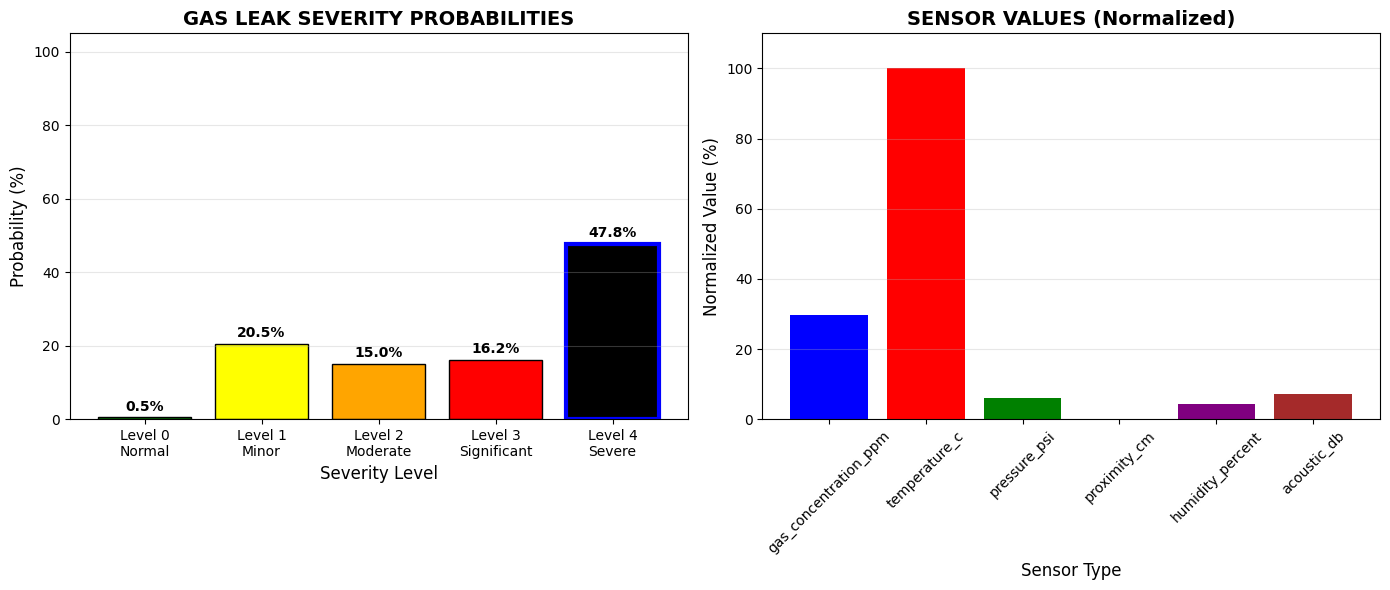


Press Enter to continue...

 MAIN MENU
1.  Enter sensor values (Custom)
2.  Run test scenarios
3.  Show model information
4.  Retrain model with current data
5.  Exit

Select option (1-5): 3

 MODEL INFORMATION

Model Type: Random Forest Classifier
Number of Trees: 100
Classes: 5 (0=Normal to 4=Severe)
Features: 6
Feature Names: gas_concentration_ppm, temperature_c, pressure_psi, proximity_cm, humidity_percent, acoustic_db

 Feature Importance:
  • gas_concentration_ppm    : 0.474
  • pressure_psi             : 0.284
  • acoustic_db              : 0.140
  • proximity_cm             : 0.053
  • temperature_c            : 0.035
  • humidity_percent         : 0.015

 Model files:
  • gas_leak_model_real.pkl: 922.6 KB
  • gas_leak_scaler_real.pkl: 1.1 KB
  • gas_leak_features_real.pkl: 0.1 KB

Press Enter to continue...5

 MAIN MENU
1.  Enter sensor values (Custom)
2.  Run test scenarios
3.  Show model information
4.  Retrain model with current data
5.  Exit

Select option (1-5): 5

 Than

In [9]:
if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n Program interrupted. Goodbye!")
    except Exception as e:
        print(f"\n Error: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nPlease check your CSV file format and try again.")